# Clasificacion clientes fuga

**Tareas relacionadas a la extraccion de datos:**

1. Generar fechas para año movil (**O**)
2. Iterar, de manera retrograda, las fechas (generar historia pasada) (**O**)
3. Generar query parametrizada por fechas (**O**)
4. Leer query desde archivo .txt (**O**)
5. Agregar columnas que identiquen periodo (fecha inicio periodo / fecha termino periodo) (**O**)
6. Generar datos de tres periodos (periodos cerrados de lo que va 2021) (**O**)


**Tareas relacionadas a la generacion de etiquetas**
1. Aplicar logicas simples (por meses de compra) a los clientes. Esto es para cada periodo (**O**)
2. A los clientes "Activos" aplicar segunda logica de contraste frecuencia vs recencia (**O**)
3. Agregar tasa de permanencia (en meses) a cada dataframe por periodo (**O**)
4. Considerar inclusion de "Clientes Nuevos", aquellos que tienen su primera compra en el último mes del periodo (**O**)
5. Considerar inclusion de ventana de tiempo de adopcion de Clientes nuevos (tiempo de permanencia en la compañia) (**X**)
6. Consolidar todos los criterios (**X**)
7. Generar evolutivo (**X**)
8. Dejar codigo "inteligente" (**X**)
9. Agregar Exclusivos TA (**X**)

In [1]:
## Librerias
import pandas as pd
import numpy  as np

import datetime
from dateutil.relativedelta import relativedelta

import os

In [2]:
## Conexion a GCP - BigQuery
import pydata_google_auth
from google.cloud import bigquery
SCOPES = [
    'https://www.googleapis.com/auth/cloud-platform',
    'https://www.googleapis.com/auth/drive',
]
credentials = pydata_google_auth.get_user_credentials(
    SCOPES,
    auth_local_webserver=True,
)
client = bigquery.Client(project='gasco-analytics', credentials=credentials)

In [3]:
## Preparacion pre iteracion

# Parametros
n_periodos = 6 #Cantidad de periodos a considerar hacia atras
fecha_referencia = datetime.datetime.today().date() #Se usa el dia actual como fecha de referencia
print(fecha_referencia)

fecha_ter_AM = fecha_referencia + relativedelta(days = -fecha_referencia.day)

fecha_ini_AM = fecha_ter_AM + relativedelta(months = -11)
fecha_ini_AM = fecha_ini_AM.replace(day = 1) 
print(fecha_ini_AM, fecha_ter_AM)

#Leemos la query y creamos lista para guardar los periodos
with open('querys\query_fuga_parametrizada.txt') as f:
    query_2 = f.read()

df = []

#Funciones de soporte
def add_quantile_columns(df, columnas = ['MESES_COMPRA','frec_compra_promedio']):
    
    df_frec_mes =  df[columnas].groupby(columnas[0]).agg([('Q1', lambda x: x.quantile(0.25)),
               ('Q2', lambda x: x.quantile(0.5)),
               ('Q3', lambda x: x.quantile(0.75)),
               ('Q90', lambda x: x.quantile(.90)),
               ('max', max),
                ('mean',np.mean)]
               ).reset_index()
    
    #Para los con solo un mes de compra, comparamos contra el maximo
    df_frec_mes[(columnas[1],'Q90')][0] = df_frec_mes[(columnas[1],'max')][0]
    
    #Clientes con una sola compra, presentan valor NA en frecuencia de compra.
    df[columnas[1]] = df[columnas[1]].fillna(0)
 
    df = df.merge(df_frec_mes, on = columnas[0])
    
    return(df)

2021-06-02
2020-06-01 2021-05-31


In [4]:
#Ciclo iterativo
read_data = False

if read_data:
    df_clientes = pd.read_csv('datos_clientes_fuga_final.csv', sep = ';', index_col = 0,
                             parse_dates = ['FECHA_PRIMER_PEDIDO','FECHA_ULTIMO_PEDIDO',
                                            'FECHA_INI_AM','FECHA_TER_AM'],
                             date_parser = pd.to_datetime)                      
else:

    for i in range(n_periodos):

        fecha_ini_iter = fecha_ini_AM + relativedelta(months = -i)
        fecha_ter_iter = fecha_ter_AM + relativedelta(months = -i)
        print(fecha_ini_iter, fecha_ter_iter)

        job_config = bigquery.QueryJobConfig(
        query_parameters=[
            bigquery.ScalarQueryParameter('INI_DATE', 'DATE', fecha_ini_iter),
            bigquery.ScalarQueryParameter('TER_DATE', 'DATE', fecha_ter_iter),
            ]
        )

        query_job = client.query(query_2, job_config = job_config)  # API request
        df_iter = query_job.to_dataframe()

        #########################################################
        #       Meses de permanencia clientes
        #########################################################   

        #Sacar hacia afuera.
        def get_diff_by_month(x):
            num_months = (fecha_ter_iter.year - x.year)*12 + (fecha_ter_iter.month - x.month)
            return(num_months)

        def str_to_date(x):
            date = datetime.datetime.strptime(x, '%Y-%m-%d')
            return(date)

        df_iter['recencia_periodo'] = (df_iter['FECHA_TER_AM'] - df_iter['FECHA_ULTIMO_PEDIDO']).apply(lambda x: x.days)
        df_iter['meses_permanencia'] = df_iter.FECHA_PRIMER_PEDIDO.apply(get_diff_by_month) + 1
        df_iter['tasa_meses'] = df_iter['MESES_COMPRA']/df_iter['meses_permanencia']

        df_iter = add_quantile_columns(df_iter)

        #########################################################
        #       Reglas Basicas actividad
        #########################################################

        choices_NB = ['activo alto','activo bajo','inactivo','nuevo']

        conditions_NB = [
             (df_iter['MESES_COMPRA'] > 7), #Activo Alto
             ((df_iter['MESES_COMPRA'] > 3)  & (df_iter['MESES_COMPRA'] <= 7)), #Activo Bajo
             ((df_iter['MESES_COMPRA'] <= 3) & (df_iter['meses_permanencia']  > 1)), #Inactivo
             ((df_iter['MESES_COMPRA'] <= 3) & (df_iter['meses_permanencia']  == 1))
        ]

        df_iter['estado_actividad'] = np.select(conditions_NB, choices_NB, default=np.nan)

        #######################################################################################
        #      Necesita calculo de cuantiles de frec_compra_promedio
        #######################################################################################


        conditions_fuga = [
               (df_iter['recencia_periodo'] >  df_iter[('frec_compra_promedio','Q3')]), 
               (df_iter['recencia_periodo'] <= df_iter[('frec_compra_promedio','Q3')])]

        choices_fuga = ['fugado','no fugado']

        df_iter['estado_fuga'] = np.select(conditions_fuga, choices_fuga, default=np.nan)
        df_iter['estado_fuga'] = np.where(df_iter['meses_permanencia'] == 1, 'nuevo', 
                                          df_iter['estado_fuga'])

        df.append(df_iter)
        
    df_clientes = pd.concat(df)
    df_clientes.to_csv('datos_clientes_fuga_final.csv', sep = ';')

2020-06-01 2021-05-31


<ipython-input-3-680fe56f7f87>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_frec_mes[(columnas[1],'Q90')][0] = df_frec_mes[(columnas[1],'max')][0]
C:\Users\fbenavides\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:618: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
C:\Users\fbenavides\Anaconda3\lib\site-packages\pandas\core\generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


2020-05-01 2021-04-30
2020-04-01 2021-03-31
2020-03-01 2021-02-28
2020-02-01 2021-01-31
2020-01-01 2020-12-31


In [5]:
df_clientes.head()

,FECHA_INI_AM,FECHA_TER_AM,TELEFONO,PEDIDOS_TA,KILOS_TA,TOTAL_PEDIDOS,TOTAL_KILOS,MESES_COMPRA,FECHA_PRIMER_PEDIDO,FECHA_ULTIMO_PEDIDO,...,meses_permanencia,tasa_meses,"(frec_compra_promedio, Q1)","(frec_compra_promedio, Q2)","(frec_compra_promedio, Q3)","(frec_compra_promedio, Q90)","(frec_compra_promedio, max)","(frec_compra_promedio, mean)",estado_actividad,estado_fuga
0,2020-06-01,2021-05-31,222242003.0,9,165,18,330,10,2020-06-22,2021-05-22,...,12,0.833333,18.4375,23.0,27.636364,31.8,40.444444,23.062856,activo alto,no fugado
1,2020-06-01,2021-05-31,228506826.0,10,110,16,176,10,2020-06-01,2021-05-17,...,12,0.833333,18.4375,23.0,27.636364,31.8,40.444444,23.062856,activo alto,no fugado
2,2020-06-01,2021-05-31,950008840.0,12,171,21,316,10,2020-06-13,2021-05-19,...,12,0.833333,18.4375,23.0,27.636364,31.8,40.444444,23.062856,activo alto,no fugado
3,2020-06-01,2021-05-31,959611178.0,11,149,18,245,10,2020-06-18,2021-04-27,...,12,0.833333,18.4375,23.0,27.636364,31.8,40.444444,23.062856,activo alto,fugado
4,2020-06-01,2021-05-31,979994289.0,7,105,16,270,10,2020-08-25,2021-05-20,...,10,1.000000,18.4375,23.0,27.636364,31.8,40.444444,23.062856,activo alto,no fugado


In [6]:
estado_actividad_mensual = df_clientes[['FECHA_TER_AM','estado_actividad','TELEFONO']].groupby(['FECHA_TER_AM','estado_actividad']).count()
estado_actividad_mensual.reset_index(inplace = True)

estado_fuga_mensual = df_clientes[['FECHA_TER_AM','estado_fuga','TELEFONO']].groupby(['FECHA_TER_AM','estado_fuga']).count()
estado_fuga_mensual.reset_index(inplace = True)

In [18]:
total = df_clientes[['FECHA_TER_AM','TELEFONO']].groupby('FECHA_TER_AM').count().reset_index()
total

,FECHA_TER_AM,TELEFONO
0,2020-12-31,610206
1,2021-01-31,614912
2,2021-02-28,619804
3,2021-03-31,625691


In [20]:
#estado_actividad_mensual.plot.bar(stacked=True)

# Testing stacked

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [49]:
df = pd.DataFrame(columns=["App","Feature1", "Feature2","Feature3",
                           "Feature4","Feature5",
                           "Feature6","Feature7","Feature8"], 
                  data=[["SHA",0,0,1,1,1,0,1,0],
                        ["LHA",1,0,1,1,0,1,1,0],
                        ["DRA",0,0,0,0,0,0,1,0],
                        ["FRA",1,0,1,1,1,0,1,1],
                        ["BRU",0,0,1,0,1,0,0,0],
                        ["PAR",0,1,1,1,1,0,1,0],
                        ["AER",0,0,1,1,0,1,1,0],
                        ["SHE",0,0,0,1,0,0,1,0]])
df

,App,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8
0,SHA,0,0,1,1,1,0,1,0
1,LHA,1,0,1,1,0,1,1,0
2,DRA,0,0,0,0,0,0,1,0
3,FRA,1,0,1,1,1,0,1,1
4,BRU,0,0,1,0,1,0,0,0
5,PAR,0,1,1,1,1,0,1,0
6,AER,0,0,1,1,0,1,1,0
7,SHE,0,0,0,1,0,0,1,0


In [50]:
sns.set()
df.set_index('App').T#.plot(kind='bar', stacked=True)

App,SHA,LHA,DRA,FRA,BRU,PAR,AER,SHE
Feature1,0,1,0,1,0,0,0,0
Feature2,0,0,0,0,0,1,0,0
Feature3,1,1,0,1,1,1,1,0
Feature4,1,1,0,1,0,1,1,1
Feature5,1,0,0,1,1,1,0,0
Feature6,0,1,0,0,0,0,1,0
Feature7,1,1,1,1,0,1,1,1
Feature8,0,0,0,1,0,0,0,0


In [62]:
estado_actividad_mensual = df_clientes[['FECHA_TER_AM','estado_actividad','TELEFONO']].groupby(['FECHA_TER_AM','estado_actividad']).count()
estado_actividad_mensual.reset_index(inplace = True)

total = estado_actividad_mensual.groupby('FECHA_TER_AM')['TELEFONO'].sum()
total.rename(columns={'TELEFONO':'TOTAL'})
total

TypeError: rename() got an unexpected keyword argument 'columns'

In [57]:
estado_actividad_mensual = estado_actividad_mensual.merge(total, how = 'left', on = 'FECHA_TER_AM')
estado_actividad_mensual

,FECHA_TER_AM,estado_actividad,TELEFONO_x,TELEFONO_y
0,2020-12-31,activo alto,22049,610206
1,2020-12-31,activo bajo,105267,610206
2,2020-12-31,inactivo,457768,610206
3,2020-12-31,nuevo,25122,610206
4,2021-01-31,activo alto,26470,614912
5,2021-01-31,activo bajo,106463,614912
6,2021-01-31,inactivo,459649,614912
7,2021-01-31,nuevo,22330,614912
8,2021-02-28,activo alto,31059,619804
9,2021-02-28,activo bajo,106308,619804


<AxesSubplot:xlabel='FECHA_TER_AM'>

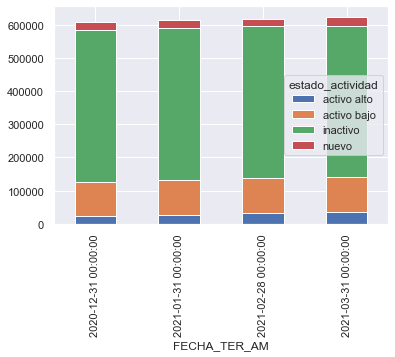

In [54]:
estado_actividad_mensual
test = pd.pivot_table(data    = estado_actividad_mensual,
                      values  = 'TELEFONO',
                      index   = 'FECHA_TER_AM',
                      columns = 'estado_actividad')#.reset_index()
test.plot(kind='bar', stacked=True)

In [ ]:
#total['TELEFONO'] = [i / j * 100 for i,j in zip(total['TELEFONO'], total['TELEFONO'])]

In [37]:
estado_actividad_mensual

,FECHA_TER_AM,estado_actividad,TELEFONO
0,2020-12-31,activo alto,22049
1,2020-12-31,activo bajo,105267
2,2020-12-31,inactivo,457768
3,2020-12-31,nuevo,25122
4,2021-01-31,activo alto,26470
5,2021-01-31,activo bajo,106463
6,2021-01-31,inactivo,459649
7,2021-01-31,nuevo,22330
8,2021-02-28,activo alto,31059
9,2021-02-28,activo bajo,106308
